In [2]:
import cv2
import numpy as np
import os
import glob

def process_image(img_path, output_folder, min_area=3000, max_hole_area=500):
    # Đọc ảnh gốc
    img = cv2.imread(img_path)
    if img is None:
        print(f"Không thể đọc ảnh: {img_path}")
        return 0
    
    original = img.copy()
    
    # Bước 1: Tách nền xanh -> lấy vùng tôm
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([140, 255, 255])
    
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 50, 255])
    mask = cv2.inRange(hsv, lower_white,upper_white)
    mask_inv = cv2.bitwise_not(mask)
    
    # Bước 2: Morphology để làm mượt mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask_clean = cv2.morphologyEx(mask_inv, cv2.MORPH_OPEN, kernel)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)
    
    # Bước 3: Fill các lỗ nhỏ bên trong vật thể 
    final_mask = mask_clean.copy()
    contours, hierarchy = cv2.findContours(mask_clean, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    if hierarchy is not None:
        for i in range(len(contours)):
            if hierarchy[0][i][3] != -1:
                area = cv2.contourArea(contours[i])
                if area < max_hole_area:
                    cv2.drawContours(final_mask, contours, i, 255, cv2.FILLED)
    
    # Bước 4: Erosion nhẹ hơn
    kernel = np.ones((3,3), np.uint8)
    eroded = cv2.erode(final_mask, kernel, iterations=1)
    
    # Bước 5: Distance transform
    dist_transform = cv2.distanceTransform(eroded, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.3*dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    
    unknown = cv2.subtract(final_mask, sure_fg)
    
    # Bước 6: Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    
    # Watershed
    markers = cv2.watershed(original, markers)
    
    # Bước 7: Lưu từng contour của tôm
    shrimp_count = 0
    global_shrimp_index = get_global_shrimp_index(output_folder)  # Lấy chỉ số tôm hiện tại
    
    for marker_id in range(2, np.max(markers)+1):
        mask = np.uint8(markers == marker_id)
        mask_full = cv2.bitwise_and(final_mask, final_mask, mask=mask)
        cnts, _ = cv2.findContours(mask_full, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in cnts:
            area = cv2.contourArea(cnt)
            if area > min_area:
                shrimp_count += 1
                global_shrimp_index += 1
                # Tạo ảnh chỉ chứa contour
                contour_img = np.zeros_like(original)
                cv2.drawContours(contour_img, [cnt], -1, (0, 255, 0), 2)
                # Lưu contour
                output_filename = os.path.join(output_folder, f"shrimp_{global_shrimp_index}.png")
                cv2.imwrite(output_filename, contour_img)
                print(f"Đã lưu contour tôm {global_shrimp_index} tại: {output_filename}")
    
    print(f"Ảnh {img_path}: Số lượng tôm đếm được: {shrimp_count}")
    return shrimp_count

# Hàm lấy chỉ số tôm hiện tại (để đánh số liên tiếp)
def get_global_shrimp_index(output_folder):
    existing_files = glob.glob(os.path.join(output_folder, "shrimp_*.png"))
    if not existing_files:
        return 0
    max_index = max([int(os.path.basename(f).split('_')[1].split('.')[0]) for f in existing_files])
    return max_index

# Hàm xử lý thư mục
def process_folder(input_folder):
    # Tạo thư mục đầu ra
    output_folder = os.path.join(os.path.dirname(input_folder), "contour_shrimp")
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Lấy danh sách tất cả các file ảnh trong thư mục
    image_extensions = ['*.jpg', '*.jpeg', '*.png']
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(input_folder, ext)))
    
    # Xử lý từng ảnh
    total_shrimp = 0
    for img_path in image_files:
        shrimp_count = process_image(img_path, output_folder)
        total_shrimp += shrimp_count
    
    print(f"Tổng số tôm đếm được từ tất cả ảnh: {total_shrimp}")

# Sử dụng hàm
input_folder = r"D:\test\estimate_shrmip\test" # Thay bằng đường dẫn thư mục của bạn
process_folder(input_folder)

Đã lưu contour tôm 1 tại: D:\test\estimate_shrmip\contour_shrimp\shrimp_1.png
Ảnh D:\test\estimate_shrmip\test\s1_1.png: Số lượng tôm đếm được: 1
Đã lưu contour tôm 2 tại: D:\test\estimate_shrmip\contour_shrimp\shrimp_2.png
Ảnh D:\test\estimate_shrmip\test\s1_2.png: Số lượng tôm đếm được: 1
Đã lưu contour tôm 3 tại: D:\test\estimate_shrmip\contour_shrimp\shrimp_3.png
Ảnh D:\test\estimate_shrmip\test\s1_3.png: Số lượng tôm đếm được: 1
Đã lưu contour tôm 4 tại: D:\test\estimate_shrmip\contour_shrimp\shrimp_4.png
Ảnh D:\test\estimate_shrmip\test\s1_4.png: Số lượng tôm đếm được: 1
Tổng số tôm đếm được từ tất cả ảnh: 4


Đọc file Excel thành công: D:\test\estimate_shrmip\DB3_INDUSTRIAL_FARM_2_C2.xlsx
Số lượng ảnh tối đa cho mỗi mẫu: 80
Đã lưu contour tôm tại: D:\test\estimate_shrmip\Countour_DB3\s1_1.png
Đã lưu contour tôm tại: D:\test\estimate_shrmip\Countour_DB3\s1_10.png
Đã lưu contour tôm tại: D:\test\estimate_shrmip\Countour_DB3\s1_11.png
Đã lưu contour tôm tại: D:\test\estimate_shrmip\Countour_DB3\s1_12.png
Đã lưu contour tôm tại: D:\test\estimate_shrmip\Countour_DB3\s1_13.png
Đã lưu contour tôm tại: D:\test\estimate_shrmip\Countour_DB3\s1_14.png
Đã lưu contour tôm tại: D:\test\estimate_shrmip\Countour_DB3\s1_15.png
Đã lưu contour tôm tại: D:\test\estimate_shrmip\Countour_DB3\s1_16.png
Đã lưu contour tôm tại: D:\test\estimate_shrmip\Countour_DB3\s1_17.png
Đã lưu contour tôm tại: D:\test\estimate_shrmip\Countour_DB3\s1_18.png
Đã lưu contour tôm tại: D:\test\estimate_shrmip\Countour_DB3\s1_19.png
Đã lưu contour tôm tại: D:\test\estimate_shrmip\Countour_DB3\s1_2.png
Đã lưu contour tôm tại: D:\test\e

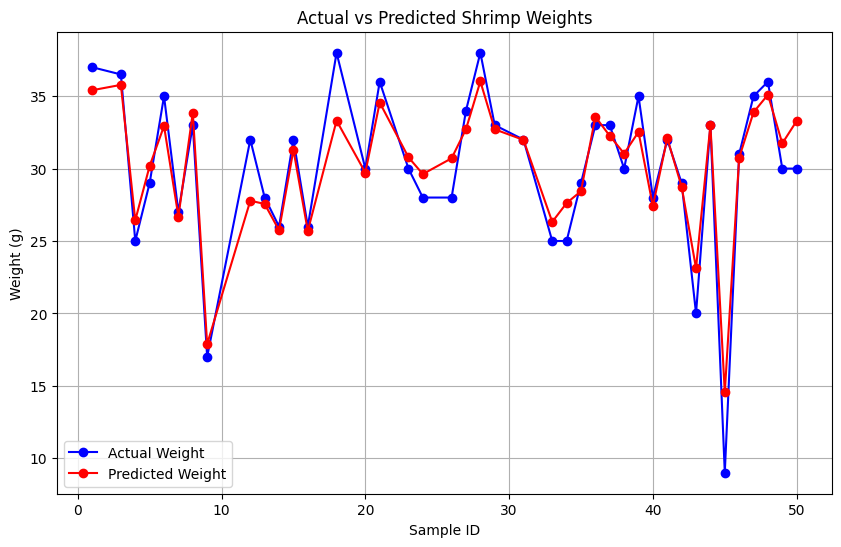

Đã lưu biểu đồ tại: shrimp_weight_prediction_plot.png
Đã lưu kết quả so sánh tại: shrimp_weight_comparison.csv


In [ ]:
import cv2
import numpy as np
import os
import glob
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

# Hàm xử lý ảnh và trích xuất đặc trưng từ contour
def process_image(img_path, output_folder, min_area=3000):
    # Đọc ảnh gốc
    img = cv2.imread(img_path)
    if img is None:
        print(f"Không thể đọc ảnh: {img_path}")
        return None
    
    # Tạo thư mục đầu ra nếu chưa tồn tại
    os.makedirs(output_folder, exist_ok=True)
    
    # Chuyển sang không gian màu HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Tách nền mờ/đục
    lower_white = np.array([0, 0,120])  # Giảm Value để bao gồm vùng tối hơn
    upper_white = np.array([180, 150, 255])  # Tăng Saturation để bao gồm màu đậm hơn
    mask_background = cv2.inRange(hsv, lower_white, upper_white)
    mask_shrimp = cv2.bitwise_not(mask_background)
    
    # Morphology làm mượt mask
    kernel = np.ones((3, 3), np.uint8)
    mask_shrimp = cv2.morphologyEx(mask_shrimp, cv2.MORPH_OPEN, kernel)
    mask_shrimp = cv2.morphologyEx(mask_shrimp, cv2.MORPH_CLOSE, kernel)
    
    # Làm rõ biên bằng ảnh xám
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    mask_shrimp = cv2.bitwise_and(mask_shrimp, mask_shrimp, mask=thresh)
    
    # Loại bỏ râu tôm bằng morphology opening
    big_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    body_mask = cv2.morphologyEx(mask_shrimp, cv2.MORPH_OPEN, big_kernel, iterations=2)
    body_mask = cv2.dilate(body_mask, big_kernel, iterations=1)
    
    # Tìm contour
    contours, _ = cv2.findContours(body_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print(f"Không tìm thấy contour trong ảnh: {img_path}")
        return None
    
    largest_contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(largest_contour)
    
    if area < min_area:
        print(f"Contour trong ảnh {img_path} có diện tích {area} nhỏ hơn ngưỡng {min_area}")
        return None
    
    perimeter = cv2.arcLength(largest_contour, True)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Lưu contour với cùng tên file
    filename = os.path.basename(img_path)
    output_filename = os.path.join(output_folder, filename)
    contour_img = np.zeros_like(img)
    cv2.drawContours(contour_img, [largest_contour], -1, (0, 255, 0), 1)
    cv2.imwrite(output_filename, contour_img)
    print(f"Đã lưu contour tôm tại: {output_filename}")
    
    return {
        'area': area,
        'perimeter': perimeter,
        'width': w,
        'height': h
    }

# Hàm chuẩn bị dữ liệu từ thư mục ảnh và file Excel
def prepare_data(image_folder, excel_path, contour_output_folder):
    # Đọc file Excel
    try:
        df = pd.read_excel(excel_path)
        print(f"Đọc file Excel thành công: {excel_path}")
    except Exception as e:
        print(f"Lỗi khi đọc file Excel: {e}")
        return np.array([]), np.array([]), []
    
    # Kiểm tra các cột cần thiết
    required_columns = ['SAMPLE', 'CEPHALOTORAX (cm)', 'LENGTH (cm)', 'WEIGHT (g)', 'COMPLETE SHRIMP IMAGES']
    if not all(col in df.columns for col in required_columns):
        print(f"File Excel thiếu một hoặc nhiều cột: {required_columns}")
        return np.array([]), np.array([]), []
    
    sample_ids = df['SAMPLE'].values
    weights = df['WEIGHT (g)'].values
    cephalothorax = df['CEPHALOTORAX (cm)'].values
    length = df['LENGTH (cm)'].values
    complete_shrimp_images = df['COMPLETE SHRIMP IMAGES'].values
    
    # Lấy danh sách ảnh (định dạng .png)
    image_files = sorted(glob.glob(os.path.join(image_folder, '*.png')))
    
    # Nhóm ảnh theo Sample ID
    shrimp_images = {}
    for img_path in image_files:
        filename = os.path.basename(img_path)
        try:
            sample_id = int(filename.split('_')[0][1:])  # Lấy sample_id từ s{sample}_x.png
            if sample_id not in shrimp_images:
                shrimp_images[sample_id] = []
            shrimp_images[sample_id].append(img_path)
        except (IndexError, ValueError):
            print(f"Tên file ảnh không đúng định dạng: {filename}")
            continue
    
    # Tìm số lượng ảnh tối đa
    max_images = max(len(images) for images in shrimp_images.values()) if shrimp_images else 0
    print(f"Số lượng ảnh tối đa cho mỗi mẫu: {max_images}")
    
    # Trích xuất đặc trưng
    X, y, valid_sample_ids = [], [], []
    for sample_id_raw, weight, ceph, len_, complete in zip(sample_ids, weights, cephalothorax, length, complete_shrimp_images):
        if complete != 1:  # Chỉ sử dụng các mẫu có COMPLETE SHRIMP IMAGES = 1
            print(f"Bỏ qua Sample ID {sample_id_raw} vì COMPLETE SHRIMP IMAGES != 1")
            continue
        
        sample_id = int(sample_id_raw)  # Ép kiểu np.int64 -> int
        if sample_id not in shrimp_images:
            print(f"Sample ID {sample_id} không có trong ảnh")
            continue
        
        features = [ceph, len_]  # Thêm CEPHALOTORAX và LENGTH
        img_count = 0
        for img_path in shrimp_images[sample_id]:
            feat = process_image(img_path, contour_output_folder)
            if feat is None:
                print(f"Bỏ qua Sample ID {sample_id} do lỗi xử lý ảnh: {img_path}")
                features = None
                break
            features.extend([feat['area'], feat['perimeter'], feat['width'], feat['height']])
            img_count += 1
        
        if features is None:  # Bỏ qua mẫu nếu có lỗi xử lý ảnh
            continue
        
        # Bổ sung giá trị 0 cho các ảnh thiếu
        while img_count < max_images:
            features.extend([0, 0, 0, 0])  # Thêm [area, perimeter, width, height] = 0
            img_count += 1
        
        X.append(features)
        y.append(weight)
        valid_sample_ids.append(sample_id)
    
    return np.array(X), np.array(y), valid_sample_ids

# Hàm huấn luyện mô hình và dự đoán
def train_and_predict(X, y, valid_sample_ids):
    # Chia dữ liệu thành tập huấn luyện và kiểm tra
    X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
        X, y, valid_sample_ids, test_size=0.2, random_state=42
    )
    
    # Huấn luyện mô hình Random Forest
    model = RandomForestRegressor(n_estimators=50, random_state=42)
    model.fit(X_train, y_train)
    
    # Dự đoán trên toàn bộ dữ liệu
    y_pred_all = model.predict(X)
    
    # Đánh giá trên tập kiểm tra
    y_pred_test = model.predict(X_test)
    print(y_test)
    print(y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    print(f"Mean Squared Error (Test): {mse:.2f}")
    print(f"R^2 Score (Test): {r2:.2f}")
    
    return model, y_pred_all, valid_sample_ids

# Hàm vẽ biểu đồ so sánh
def plot_predictions(sample_ids, actual_weights, predicted_weights):
    plt.figure(figsize=(10, 6))
    plt.plot(sample_ids, actual_weights, 'bo-', label='Actual Weight')
    plt.plot(sample_ids, predicted_weights, 'ro-', label='Predicted Weight')
    plt.xlabel('Sample ID')
    plt.ylabel('Weight (g)')
    plt.title('Actual vs Predicted Shrimp Weights')
    plt.legend()
    plt.grid(True)
    plt.savefig('shrimp_weight_prediction_plot.png')
    plt.show()
    print("Đã lưu biểu đồ tại: shrimp_weight_prediction_plot.png")

# Hàm lưu kết quả so sánh vào file CSV
def save_comparison_csv(sample_ids, actual_weights, predicted_weights, output_csv):
    df = pd.DataFrame({
        'Sample': sample_ids,
        'Actual_Weight': actual_weights,
        'Predicted_Weight': predicted_weights
    })
    df.to_csv(output_csv, index=False)
    print(f"Đã lưu kết quả so sánh tại: {output_csv}")

# Hàm chính
def main():
    image_folder = r"D:\test\estimate_shrmip\DB3"  # Thư mục chứa ảnh tôm
    excel_path = r"D:\test\estimate_shrmip\DB3_INDUSTRIAL_FARM_2_C2.xlsx"  # File Excel
    contour_output_folder = r"D:\test\estimate_shrmip\Countour_DB3"  # Thư mục lưu contour
    output_model = "shrimp_weight_prediction_model.pkl"
    output_csv = "shrimp_weight_comparison.csv"
    
    # Chuẩn bị dữ liệu
    X, y, valid_sample_ids = prepare_data(image_folder, excel_path, contour_output_folder)
    if len(X) == 0:
        print("Không có dữ liệu hợp lệ để huấn luyện.")
        return
    
    # Huấn luyện mô hình và dự đoán
    model, y_pred, sample_ids = train_and_predict(X, y, valid_sample_ids)
    
    # Lưu mô hình
    joblib.dump(model, output_model)
    print(f"Đã lưu mô hình tại: {output_model}")
    
    # Vẽ biểu đồ
    plot_predictions(sample_ids, y, y_pred)
    
    # Lưu kết quả so sánh vào CSV
    save_comparison_csv(sample_ids, y, y_pred, output_csv)

if __name__ == "__main__":
    main()

Đọc file Excel thành công: D:\test\estimate_shrmip\DB3_INDUSTRIAL_FARM_2_C2.xlsx
Số lượng ảnh tối đa cho mỗi mẫu: 80
Đã lưu contour tôm tại: D:\test\estimate_shrmip\contour_shrimp\s1_1.png
Đã lưu contour tôm tại: D:\test\estimate_shrmip\contour_shrimp\s1_10.png
Đã lưu contour tôm tại: D:\test\estimate_shrmip\contour_shrimp\s1_11.png
Đã lưu contour tôm tại: D:\test\estimate_shrmip\contour_shrimp\s1_12.png
Đã lưu contour tôm tại: D:\test\estimate_shrmip\contour_shrimp\s1_13.png
Đã lưu contour tôm tại: D:\test\estimate_shrmip\contour_shrimp\s1_14.png
Đã lưu contour tôm tại: D:\test\estimate_shrmip\contour_shrimp\s1_15.png
Đã lưu contour tôm tại: D:\test\estimate_shrmip\contour_shrimp\s1_16.png
Đã lưu contour tôm tại: D:\test\estimate_shrmip\contour_shrimp\s1_17.png
Đã lưu contour tôm tại: D:\test\estimate_shrmip\contour_shrimp\s1_18.png
Đã lưu contour tôm tại: D:\test\estimate_shrmip\contour_shrimp\s1_19.png
Đã lưu contour tôm tại: D:\test\estimate_shrmip\contour_shrimp\s1_2.png
Đã lưu co

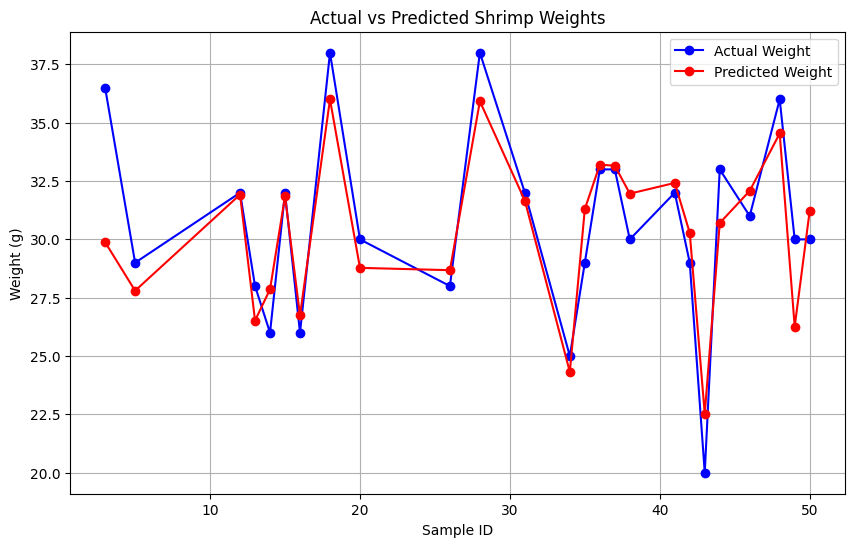

Đã lưu biểu đồ tại: shrimp_weight_prediction_plot.png
Đã lưu kết quả so sánh tại: shrimp_weight_comparison_image_only.csv
Đã lưu max_images (80) tại: max_images.txt


In [11]:
import cv2
import numpy as np
import os
import glob
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

# Hàm xử lý ảnh và trích xuất đặc trưng từ contour
def process_image(img_path, output_folder, min_area=3000):
    # Đọc ảnh gốc
    img = cv2.imread(img_path)
    if img is None:
        print(f"Không thể đọc ảnh: {img_path}")
        return None
    
    # Tạo thư mục đầu ra nếu chưa tồn tại
    os.makedirs(output_folder, exist_ok=True)
    
    # Chuyển sang không gian màu HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Tách nền mờ/đục
    lower_white = np.array([0, 0, 100])
    upper_white = np.array([180, 150, 255])
    mask_background = cv2.inRange(hsv, lower_white, upper_white)
    mask_shrimp = cv2.bitwise_not(mask_background)
    
    # Morphology làm mượt mask
    kernel = np.ones((10, 10), np.uint8)
    mask_shrimp = cv2.morphologyEx(mask_shrimp, cv2.MORPH_OPEN, kernel)
    
    kernel = np.ones((3, 3), np.uint8)
    mask_shrimp = cv2.morphologyEx(mask_shrimp, cv2.MORPH_CLOSE, kernel)
    
    # Làm rõ biên bằng ảnh xám
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    mask_shrimp = cv2.bitwise_and(mask_shrimp, mask_shrimp, mask=thresh)
    
    # Loại bỏ râu tôm bằng morphology opening
    big_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    body_mask = cv2.morphologyEx(mask_shrimp, cv2.MORPH_OPEN, big_kernel, iterations=2)
    body_mask = cv2.dilate(body_mask, big_kernel, iterations=1)
    
    # Tìm contour
    contours, _ = cv2.findContours(body_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print(f"Không tìm thấy contour trong ảnh: {img_path}")
        return None
    
    largest_contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(largest_contour)
    
    if area < min_area:
        print(f"Contour trong ảnh {img_path} có diện tích {area} nhỏ hơn ngưỡng {min_area}")
        return None
    
    perimeter = cv2.arcLength(largest_contour, True)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Lưu contour với cùng tên file
    filename = os.path.basename(img_path)
    output_filename = os.path.join(output_folder, filename)
    contour_img = np.zeros_like(img)
    cv2.drawContours(contour_img, [largest_contour], -1, (0, 255, 0), 1)
    cv2.imwrite(output_filename, contour_img)
    print(f"Đã lưu contour tôm tại: {output_filename}")
    
    return {
        'area': area,
        'perimeter': perimeter,
        'width': w,
        'height': h
    }

# Hàm chuẩn bị dữ liệu từ thư mục ảnh và file Excel
def prepare_data(image_folder, excel_path, contour_output_folder):
    # Đọc file Excel
    try:
        df = pd.read_excel(excel_path)
        print(f"Đọc file Excel thành công: {excel_path}")
    except Exception as e:
        print(f"Lỗi khi đọc file Excel: {e}")
        return np.array([]), np.array([]), []
    
    # Kiểm tra các cột cần thiết
    required_columns = ['SAMPLE', 'WEIGHT (g)', 'COMPLETE SHRIMP IMAGES']
    if not all(col in df.columns for col in required_columns):
        print(f"File Excel thiếu một hoặc nhiều cột: {required_columns}")
        return np.array([]), np.array([]), []
    
    sample_ids = df['SAMPLE'].values
    weights = df['WEIGHT (g)'].values
    complete_shrimp_images = df['COMPLETE SHRIMP IMAGES'].values
    
    # Lấy danh sách ảnh (định dạng .png)
    image_files = sorted(glob.glob(os.path.join(image_folder, '*.png')))
    
    # Nhóm ảnh theo Sample ID
    shrimp_images = {}
    for img_path in image_files:
        filename = os.path.basename(img_path)
        try:
            sample_id = int(filename.split('_')[0][1:])  # Lấy sample_id từ s{sample}_x.png
            if sample_id not in shrimp_images:
                shrimp_images[sample_id] = []
            shrimp_images[sample_id].append(img_path)
        except (IndexError, ValueError):
            print(f"Tên file ảnh không đúng định dạng: {filename}")
            continue
    
    # Tìm số lượng ảnh tối đa
    max_images = max(len(images) for images in shrimp_images.values()) if shrimp_images else 0
    print(f"Số lượng ảnh tối đa cho mỗi mẫu: {max_images}")
    
    # Trích xuất đặc trưng
    X, y, valid_sample_ids = [], [], []
    for sample_id_raw, weight, complete in zip(sample_ids, weights, complete_shrimp_images):
        if complete != 1:  # Chỉ sử dụng các mẫu có COMPLETE SHRIMP IMAGES = 1
            print(f"Bỏ qua Sample ID {sample_id_raw} vì COMPLETE SHRIMP IMAGES != 1")
            continue
        
        sample_id = int(sample_id_raw)  # Ép kiểu np.int64 -> int
        if sample_id not in shrimp_images:
            print(f"Sample ID {sample_id} không có trong ảnh")
            continue
        
        features = []  # Chỉ sử dụng đặc trưng từ ảnh
        img_count = 0
        for img_path in shrimp_images[sample_id]:
            feat = process_image(img_path, contour_output_folder)
            if feat is None:
                print(f"Bỏ qua Sample ID {sample_id} do lỗi xử lý ảnh: {img_path}")
                features = None
                break
            features.extend([feat['area'], feat['perimeter'], feat['width'], feat['height']])
            img_count += 1
        
        if features is None:  # Bỏ qua mẫu nếu có lỗi xử lý ảnh
            continue
        
        # Bổ sung giá trị 0 cho các ảnh thiếu
        while img_count < max_images:
            features.extend([0, 0, 0, 0])  # Thêm [area, perimeter, width, height] = 0
            img_count += 1
        
        X.append(features)
        y.append(weight)
        valid_sample_ids.append(sample_id)
    
    return np.array(X), np.array(y), valid_sample_ids, max_images

# Hàm huấn luyện mô hình và dự đoán
def train_and_predict(X, y, valid_sample_ids):
    # Chia dữ liệu thành tập huấn luyện và kiểm tra
    X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
        X, y, valid_sample_ids, test_size=0.2, random_state=42
    )
    
    # Huấn luyện mô hình Random Forest
    model = RandomForestRegressor(n_estimators=50, random_state=42)
    model.fit(X_train, y_train)
    
    # Dự đoán trên toàn bộ dữ liệu
    y_pred_all = model.predict(X)
    
    # Đánh giá trên tập kiểm tra
    y_pred_test = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    print(f"Mean Squared Error (Test): {mse:.2f}")
    print(f"R^2 Score (Test): {r2:.2f}")
    
    return model, y_pred_all, valid_sample_ids

# Hàm vẽ biểu đồ so sánh
def plot_predictions(sample_ids, actual_weights, predicted_weights):
    plt.figure(figsize=(10, 6))
    plt.plot(sample_ids, actual_weights, 'bo-', label='Actual Weight')
    plt.plot(sample_ids, predicted_weights, 'ro-', label='Predicted Weight')
    plt.xlabel('Sample ID')
    plt.ylabel('Weight (g)')
    plt.title('Actual vs Predicted Shrimp Weights')
    plt.legend()
    plt.grid(True)
    plt.savefig('shrimp_weight_prediction_plot.png')
    plt.show()
    print("Đã lưu biểu đồ tại: shrimp_weight_prediction_plot.png")

# Hàm lưu kết quả so sánh vào file CSV
def save_comparison_csv(sample_ids, actual_weights, predicted_weights, output_csv):
    df = pd.DataFrame({
        'Sample': sample_ids,
        'Actual_Weight': actual_weights,
        'Predicted_Weight': predicted_weights
    })
    df.to_csv(output_csv, index=False)
    print(f"Đã lưu kết quả so sánh tại: {output_csv}")

# Hàm chính
def main():
    image_folder = r"D:\test\estimate_shrmip\DB3"  # Thư mục chứa ảnh tôm
    excel_path = r"D:\test\estimate_shrmip\DB3_INDUSTRIAL_FARM_2_C2.xlsx"  # File Excel
    contour_output_folder = r"D:\test\estimate_shrmip\contour_shrimp"  # Thư mục lưu contour
    output_model = "shrimp_weight_prediction_image_only.pkl"  # File mô hình mới
    output_csv = "shrimp_weight_comparison_image_only.csv"  # File CSV kết quả
    
    # Chuẩn bị dữ liệu
    X, y, valid_sample_ids, max_images = prepare_data(image_folder, excel_path, contour_output_folder)
    if len(X) == 0:
        print("Không có dữ liệu hợp lệ để huấn luyện.")
        return
    
    # Huấn luyện mô hình và dự đoán
    model, y_pred, sample_ids = train_and_predict(X, y, valid_sample_ids)
    
    # Lưu mô hình
    joblib.dump(model, output_model)
    print(f"Đã lưu mô hình tại: {output_model}")
    
    # Vẽ biểu đồ
    plot_predictions(sample_ids, y, y_pred)
    
    # Lưu kết quả so sánh vào CSV
    save_comparison_csv(sample_ids, y, y_pred, output_csv)
    
    # Lưu max_images để sử dụng khi dự đoán
    with open('max_images.txt', 'w') as f:
        f.write(str(max_images))
    print(f"Đã lưu max_images ({max_images}) tại: max_images.txt")

if __name__ == "__main__":
    main()

In [17]:
import cv2
import numpy as np
import os
import pandas as pd
import joblib
import time

# Hàm xử lý ảnh và trích xuất đặc trưng từ contour
def process_image(img_path, output_folder, min_area=3000):
    """
    Hàm xử lý một ảnh để tách contour tôm và trích xuất đặc trưng.
    Input: Đường dẫn ảnh (img_path), thư mục lưu contour (output_folder), diện tích tối thiểu (min_area).
    Output: Dictionary chứa đặc trưng (area, perimeter, width, height) hoặc None nếu xử lý thất bại.
    """
    # --- Bắt đầu xử lý ảnh và tách contour ---
    # Đọc ảnh gốc
    img = cv2.imread(img_path)
    if img is None:
        return None  # Không in lỗi, trả về None để xử lý ở hàm gọi
    
    # Tạo thư mục đầu ra nếu chưa tồn tại
    os.makedirs(output_folder, exist_ok=True)
    
    # Chuyển sang không gian màu HSV để tách nền
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Tách nền mờ/đục
    lower_white = np.array([0, 0, 100])  # Ngưỡng dưới cho nền (Hue, Saturation, Value)
    upper_white = np.array([180, 150, 255])  # Ngưỡng trên cho nền
    mask_background = cv2.inRange(hsv, lower_white, upper_white)
    mask_shrimp = cv2.bitwise_not(mask_background)  # Đảo mask để lấy tôm
    
    # Morphology làm mượt mask
    kernel = np.ones((10, 10), np.uint8)
    mask_shrimp = cv2.morphologyEx(mask_shrimp, cv2.MORPH_OPEN, kernel)
    
    kernel = np.ones((3, 3), np.uint8)
    mask_shrimp = cv2.morphologyEx(mask_shrimp, cv2.MORPH_CLOSE, kernel)
    
    # Làm rõ biên bằng ảnh xám
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    mask_shrimp = cv2.bitwise_and(mask_shrimp, mask_shrimp, mask=thresh)
    
    # Loại bỏ râu tôm bằng morphology opening
    big_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    body_mask = cv2.morphologyEx(mask_shrimp, cv2.MORPH_OPEN, big_kernel, iterations=2)
    body_mask = cv2.dilate(body_mask, big_kernel, iterations=1)
    
    # Tìm contour
    contours, _ = cv2.findContours(body_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None  # Không in lỗi, trả về None
    
    largest_contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(largest_contour)
    
    if area < min_area:
        return None  # Không in lỗi, trả về None
    
    perimeter = cv2.arcLength(largest_contour, True)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Lưu contour với cùng tên file
    filename = os.path.basename(img_path)
    output_filename = os.path.join(output_folder, filename)
    contour_img = np.zeros_like(img)
    cv2.drawContours(contour_img, [largest_contour], -1, (0, 255, 0), 1)
    cv2.imwrite(output_filename, contour_img)
    
    # --- Kết thúc xử lý ảnh và tách contour ---
    
    return {
        'area': area,
        'perimeter': perimeter,
        'width': w,
        'height': h
    }

# Hàm chuẩn bị dữ liệu đầu vào từ một ảnh
def prepare_input_data(img_path, contour_output_folder, max_images):
    """
    Hàm chuẩn bị dữ liệu đầu vào từ một ảnh.
    Input: Đường dẫn ảnh (img_path), thư mục lưu contour, số ảnh tối đa (max_images).
    Output: Mảng đặc trưng X và sample_id, hoặc None nếu xử lý thất bại.
    """
    # Lấy sample_id từ tên file ảnh
    try:
        filename = os.path.basename(img_path)
        sample_id = int(filename.split('_')[0][1:])  # Lấy sample_id từ s{sample}_x.png
    except (IndexError, ValueError):
        return None, None  # Không in lỗi, trả về None
    
    # Trích xuất đặc trưng
    feat = process_image(img_path, contour_output_folder)
    if feat is None:
        return None, None  # Không in lỗi, trả về None
    
    # Tạo vector đặc trưng
    features = [feat['area'], feat['perimeter'], feat['width'], feat['height']]
    img_count = 1
    
    # Bổ sung giá trị 0 cho các ảnh thiếu
    while img_count < max_images:
        features.extend(feat['area'], feat['perimeter'], feat['width'], feat['height'])  # Thêm [area, perimeter, width, height] = 0
        img_count += 1
    
    return np.array([features]), sample_id

# Hàm dự đoán khối lượng tôm
def predict_shrimp_weight(model_path, img_path, contour_output_folder, max_images):
    """
    Hàm load mô hình và dự đoán khối lượng tôm từ một ảnh.
    Input: Đường dẫn mô hình, đường dẫn ảnh, thư mục lưu contour, số ảnh tối đa.
    Output: Sample ID, khối lượng dự đoán, và thời gian xử lý.
    """
    # Load mô hình
    start_time = time.time()  # Bắt đầu đo thời gian
    try:
        model = joblib.load(model_path)
    except Exception as e:
        return None, None, 0  # Không in lỗi, trả về None và thời gian 0
    
    # Chuẩn bị dữ liệu đầu vào
    X, sample_id = prepare_input_data(img_path, contour_output_folder, max_images)
    if X is None or sample_id is None:
        return None, None, 0  # Không in lỗi, trả về None và thời gian 0
    
    # Dự đoán
    y_pred = model.predict(X)
    
    end_time = time.time()  # Kết thúc đo thời gian
    processing_time = end_time - start_time
    
    return sample_id, y_pred[0], processing_time

# Hàm lưu kết quả dự đoán vào file CSV
def save_prediction_csv(sample_id, predicted_weight, processing_time, output_csv):
    """
    Hàm lưu kết quả dự đoán vào file CSV.
    Input: Sample ID, khối lượng dự đoán, thời gian xử lý, đường dẫn file CSV.
    Output: File CSV chứa kết quả.
    """
    df = pd.DataFrame({
        'Sample': [sample_id],
        'Predicted_Weight': [predicted_weight],
        'Processing_Time_s': [processing_time]
    })
    df.to_csv(output_csv, index=False)

# Hàm chính
def main():
    """
    Hàm chính để dự đoán khối lượng tôm từ một ảnh và lưu kết quả vào CSV.
    """
    # Đường dẫn và tham số
    model_path = "shrimp_weight_prediction_image_only.pkl"  # Đường dẫn đến mô hình
    img_path = r"D:\test\estimate_shrmip\DB3\s1_4.png"  # Đường dẫn ảnh đầu vào
    contour_output_folder = r"D:\test\estimate_shrmip\contour_shrimp"  # Thư mục lưu contour
    output_csv = "shrimp_weight_prediction_image_only.csv"  # File CSV lưu kết quả
    
    # Load max_images từ file
    try:
        with open('max_images.txt', 'r') as f:
            max_images = int(f.read())
    except Exception:
        max_images = 38  # Mặc định nếu không tìm thấy file
    
    # Dự đoán
    sample_id, predicted_weight, processing_time = predict_shrimp_weight(model_path, img_path, contour_output_folder, max_images)
    if sample_id is None or predicted_weight is None:
        return
    
    # Lưu kết quả vào CSV
    save_prediction_csv(sample_id, predicted_weight, processing_time, output_csv)

if __name__ == "__main__":
    main()

TypeError: list.extend() takes exactly one argument (4 given)